<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Volume-Variance Relations

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Volume-Variance Relations**. It is critical to remember:

* all spatial statistics have an implicit scale assumption

For example, as the scale, volume support, increases the variance reduces.

**YouTube Lecture**: check out my lecture on:
        
* [Scale](https://youtu.be/suWCmal03Rg?si=XEtIlBlgP175qkUb)
* [Dispersion Variance](https://youtu.be/UI81msM0wXQ?si=Ige9n70STMfC6kwU)
* [Scaling Statistics](https://youtu.be/MM7Tn8TU5Bk?si=0GVOKJ6nYx1cib28)
    
For your convenience here's a summary of salient points. Let's start with volume variance relations and then methods to correct the variance for changes in volume, i.e., support volume of data and models within the area of interest.

#### Volume Variance Relations

**Volume-variance Relations** - as the volume support increases the variance at that volume support reduces. To observe this effect, look at this example where I took a simulated model and numerically upscaled by averaging to a larger model volume support.

* the variance of the model histogram is reduced as volume support increases

<figure style="text-align: center;">
  <img src="_static/scale/volumevar.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;"> A simulated model numerically upscaled by averaging to a larger model volume support, and the resulting reduction in variance in the model histogram.
</figcaption>
</figure>

Predicting this behavior is central to handling multiple scales of data and estimation because,

* the histogram is typically an input for our models, and unless we correct for volume-variance relations, we will inflate the variance in our models, by using the original data volume support distribution to populate the larger volume support model cells.

Let's make some observations about volume-variance relations, that we will demonstration below with our examples,

* **volume support** is the term we use for the scale of the data or model. It is specified by the extent of the data or model cells in each dimension. For example, the model cells are $10 m \times 10 m \times 1 m$ or the core plug is $10 cm$ in length with a diameter of $4 cm$.   

* in general, change in volume support, should not change the mean of the distribution, volume-variance relations is focused on the change in variance

* there may be a distribution shape change. Best practice is to check shape change empirically. It is common to assume no shape change (affine distribution correction) or to use a simple shape change model (indirect lognormal correction) discussed below

* the variance reduction in the distribution is inversely proportional to the range of spatial continuity  

* over common changes in volume support volume-variance is often significant, it is dangerous to ignore volume-variance relations 

So, the variance will change with change in volume support and this change can be calculated by,

* **empirical** - take the original model at initial volume support and numerically upscale the model to new larger volume support model cells and evaluate the variance and entire distribution shape over the upscaled model

* **analytical** - calculate the variance reduction factor, $f$, with dispersion variance, and then apply this variance reduction factor to calculate the new volume support corrected variance, and apply this to a change of support model to upscale the distribution


#### Empirical Variance Correction

The general empirical variance correction method is to build a small scale, high resolution model, and then numerically scale it up. 

<figure style="text-align: center;">
  <img src="_static/scale/empirical.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;"> Initial model (left) and scaled-up model (right). Volume support is increased by doubling the extent of the model cells by average over $2 \times 2$ cells. 
</figcaption>
</figure>

* empirical scale up requires a model for spatial feature scale up

For example, averaging the small scale cells within the larger scale cell, assumes the spatial feature averages linearly, 

$$
z_V = \left[ \frac{1}{n} \sum z_v \right] 
$$
 
and there is a more flexible model known as power law averaging for features that do not average linearly,

$$
z_V = \left[ \frac{1}{n} \sum z_v^{\omega} \right] ^{\frac{1}{\omega}}
$$

where $\omega$ is the power of averaging. For example:

* $\omega = 1$ is a regular linear averaging
* $\omega = -1$ is a harmonic averaging 
* $\omega = 0$ is a geometric averaging (this is proved in the limit as $\omega \rightarrow 0$)

An advantage of the empirical variance correction,

* the method is general and can be applied to any model or data given there is an exhaustive representation, i.e., values at all locations that can be scaled up

* there is no restriction to a specific type of spatial continuity model, for example, a variogram model, or even a requirement that the model is hyperrectangle or even a contiguous model volume of interest

* the method provides the corrected distribution, without need to assume a change of variance model (see below)

A disadvantage is,

* the method cannot be applied to sparsely sampled data, unless first we simulate an exhaustive model at a high resolution, small volume support

We will demonstrate empirical variance correction below, now I explain the alternative, analytical approach with dispersion variance. 


#### Dispersion Variance

Dispersion variance is a generalized form of variance that accounts for the volume support of the samples, $\cdot$, or model, $v$, and the volume of interest, $V$ represents. 

* we can calculate the correct variance for any support volume, given the volume and the variogram

Dispersion variance for data volume support within the model volume support, for example drill hole and well cores and logs within the volume of interest, is stated as,

$$
D^2(\cdot, V) 
$$

where we read this as the dispersion variance, $D^2$, of samples at the original data volume support, $\cdot$, within the volume of interest, $V$. 

The dispersion variance for model volume support, $v$, is stated as,

$$
D^2(v, V) 
$$

where we read this as the dispersion variance, $D^2$, of model cells at their specific volume support, $v$, within the volume of interest, $V$.

The case of dispersion variance of data volume support within the volume of interest, simplifies to the regular variance,

$$
\sigma^2 = D^2(\cdot,V) = \frac{1}{n}\sum_i^n \left(x_i - \overline{x} \right)^2
$$

therefore, the well-known variance is a special case of dispersion variance! 

Dispersion variance under the assumption of stationary mean, variance and variogram can be calculated with,

* each of the volumes, $\cdot$ or $v$, and $V$, i.e., the extents in 1D, 2D or 3D

* the positive definite variogram model in the 1D, 2D, or 3D 

This is accomplished with gammabar, $\overline{\gamma}$, values. For example, the variance of the model cells in the volume of interest can be calculated as,

$$
D^2(v,V) = \overline{\gamma}_{V,V} - \overline{\gamma}_{v,v} 
$$

where $\overline{\gamma}_{V,V}$ and $\overline{\gamma}_{v,v}$ are variogram models integrated over volume $V$ and $v$ respectively. 


#### Gammabar

Gammabar, $\overline{\gamma}(V_1,V_2)$ is the volume integrated variogram where the tail, $u$, describes the first volume, $V_1$, and the head, $u^{\prime}$, describes the second volume, $V_2$.

$$
\overline{\gamma}(V_1,V_2) = \frac{1}{V_1 \cdot V_2} \int_{u} \int_{u^{\prime}} \gamma(y, y^{\prime}) dy^{\prime} dy
$$

I illustrate gammabar with this figure,

<figure style="text-align: center;">
  <img src="_static/scale/gammabar.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;">  Gammabar is the volume integrated variogram where the tail, \(u\), describes the first volume, \(V_1\), and the head, \(u^{\prime}\), describes the second volume, \(V_2\).
</figcaption>
</figure>

While I only draw two vectors between both volumes, the integration is performed over the combinatorial of possible head and tail locations that completely describe both volumes.

* gammabar is generally approximated by discretizing each volume with $n$ equally spaced points in each dimension and then calculating the average of the variogram over all combinations of points.

* typically $5 \times 5$ discretization provides sufficient accuracy in 3D

<figure style="text-align: center;">
  <img src="_static/scale/gammabarnumerical.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;">  Gammabar is the volume integrated variogram where the tail, \(u\), describes the first volume, \(V_1\), and the head, \(u^{\prime}\), describes the second volume, \(V_2\). Calculated by discretizing the two volumes with $3 \times 3$ equally spaced points and calculating the average variogram of over the combinatorial.
</figcaption>
</figure>

* if both volumes are the same, we do not include cases where the head and tail location are at the same location to avoid a bias in our gammabar calculation

Of course, gammabar is general, for example we could calculate gammabar in the cases of,

* one volume is inside the other volume, i.e., the case of model cells inside the model

* both volumes are the same, i.e., the case of $\overline{\gamma}_{V,V}$ and $\overline{\gamma}_{v,v}$ above

* the volume(s) are not contiguous, this is rarely done, but it is possible

To support your intuition, let's make some general gammabar observations,

* shorter variogram range will increase the gammabar value, generally resulting in larger variogram values for every $y$ to $y^{\prime}$ vector

* if one or both volume increase then gammabar will increase, given the variogram monotonically increases and larger volumes result longer vectors, $y$ to $y^{\prime}$ 

* if the seperation distance between the volumes increases, gammabar will increase, given the variogram monotonically increases and larger seperation results in longer vectors, $y$ to $y^{\prime}$ between the volumes 


#### Variance Reduction Factor, $f$

Now we can take the volumes, variogram with gammabar and calculate the variance reduction value, 

$$
f = \frac{\text{Upscaled Variance}}{\text{Data or Model Variance}}
$$

For the case of going from data volume support to model volume support, the variance reduction factor is calculated as,

$$
f = \frac{D^2(v,V)}{D^2(\cdot,V)} = \frac{D^2(v,V)}{D^2(\cdot,V)}
$$

in other words, $f$ is the ratio of the variance at model volume support, $v$ to the variance at the original data volume support, $\cdot$. Given,

$$
D^2(\cdot,V) = \sigma^2
$$

our dispersion variance at data volume support is the regular variance, we can simplify the equation as,

$$
f = \frac{D^2(v,V)}{D^2(\cdot,V)} = \frac{D^2(v,V)}{\sigma^2}
$$

Now we can substitute the gammabar to calculate our model volume support dispersion variance,

$$
f = \frac{\overline{\gamma}(V,V) - \overline{\gamma}(v,v)}{\sigma^2}
$$

if the volume of interest is large relative to the variogram range, $\overline{\gamma}(V,V)$ approaches the variance, $\sigma^2$.

$$
f = \frac{\sigma^2 - \overline{\gamma}(v,v)}{\sigma^2} = \frac{\sigma^2}{\sigma^2} - \frac{\overline{\gamma}(v,v)}{\sigma^2}
$$

and we can simplify this as,

$$
f = 1 - \frac{\overline{\gamma}(v,v)}{\sigma^2}
$$


#### Volume-Variance Correction of the Distribution

Once we have a variance reduction factor, we need to correct the distribution. There are various models including,

* **affine correction** - assumes squeezing about the mean, without any change in shape model

* **indirect lognormal** - assumes lognormal distribution of the feature

* **discrete Gaussian model** - based on Hermite polynomials

Let's cover the affine correction method that is demonstrated below.

Affine correction is applied to,

* center the distribution on 0.0

* scale the variance

* restore the original mean

The equation is,

$$
q^{\prime} = \sqrt{f} \cdot \left( q - m \right) + m
$$

where $q$ is the original data value, $m$ is the mean, and $f$ is the variance reduction factor. Note, we take the square root as the affine correction is based on the ratio of standard deviations instead of variances.

In this chapter I provide,

* simple empirical, numerical demonstrations of the impact of change on scale on variance and the impact of spatial continuity on this effect 

and then,

* a workflow to calculate the variance reduction factor $f$ with a simple demonstration


#### Krige's Relation

As we determine model support volume, it is useful to remember that variance is conserved, i.e., 

* the variance within the model cells plus the variance between the model cells is equal to the total variance

This concept is communicated with Krige's relation with dispersion variance as,

$$
D^2(\cdot,V) = D^2(\cdot,v) + D^2(v,V)
$$

Another way to think of this, when we select model cell sizes, we are partitioning the variance into and between the model cells!


#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import math                                                   # square root
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
from tqdm import tqdm                                         # progress bar
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map for plotting 

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

We use GeostatsPy, but we need a new upscale (linear averaging) method and a plotting method that does not interpolate. I will add these to GeostatsPy shortly.

In [3]:
def getindex(nc,cmn,csiz,loc):                                # take location and grid and find the cell
    ic = min(int((loc - cmn) / csiz), nc - 1)
    return ic

def upscale(model,new_nx,new_ny):                             # scale up model with linear averaging
    ny, nx = model.shape
    new_xsiz = nx/new_nx; new_xmn = new_xsiz * 0.5
    new_ysiz = ny/new_ny; new_ymn = new_ysiz * 0.5
    new_model = np.zeros((new_ny,new_nx)); count = np.zeros((new_ny,new_nx))
    for iy in range(0,ny):
        yloc = iy+0.5
        new_iy = getindex(new_ny,new_ymn,new_ysiz,yloc)
        for ix in range(0,nx):
            xloc = ix+0.5
            new_ix = getindex(new_nx,new_xmn,new_xsiz,xloc)
            new_model[new_iy,new_ix] = new_model[new_iy,new_ix] + model[iy,ix] 
            count[new_iy,new_ix] = count[new_iy,new_ix] + 1 
    for iny in range(0,new_ny):
        for inx in range(0,new_nx):
            if count[iny,inx] > 0:
                new_model[iny,inx] = new_model[iny,inx] / count[iny,inx]
    return new_model

def cellplt_st(array,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    im = plt.imshow(array,cmap,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20) 

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

def generate_cell_centered_points(n_cells, extent):
    # Calculate the spacing between cells
    spacing = extent / n_cells

    # Create a grid of cell centers
    points = []
    
    for i in range(n_cells):
        for j in range(n_cells):
            # Calculate the center of each cell
            x_center = (i + 0.5) * spacing
            y_center = (j + 0.5) * spacing
            points.append((x_center, y_center))
    return points
    
def gammabar(size,ndiscr,vario):
    nst = int(vario['nst'])
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst,dtype=int)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']
    if vario['hmaj1'] == 0.0:
        anis[0] = 1.0
    else:
        anis[0] = vario['hmin1']/vario['hmaj1']
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; 
        if vario['hmaj1'] == 0.0:
            anis[1] = 1.0
        else:
            anis[1] = vario['hmin2']/vario['hmaj2']           
    radius = max(vario['hmaj1'],vario['hmaj2'])
    radius1 = max(vario['hmin1'],vario['hmin2'])
    sanis1 = radius1/radius
    if vario['hmaj2'] > vario['hmaj1']:
        sang1 = vario['azi2'] # use the angle for the longest range
    else:
        sang1 = vario['azi1']
    rotmat_2d, maxcov = geostats.setup_rotmat2(c0,nst,it,cc,ang) # will use one in the future
    points = generate_cell_centered_points(ndiscr, size)
    gb = 0.0; count = 0
    for i in range(len(points)):
        for j in range(i, len(points)):  # Start from i to include self-pairs
            if i != j:  # Ensure no same point is paired with itself
                point1 = points[i]
                point2 = points[j]
                cov = geostats.cova2(point1[0],point1[1],point2[0],point2[1],nst,c0,9999.9,cc,aa,it,ang,anis,rotmat_2d,maxcov)
                gb += maxcov-cov
                count = count + 1
    return gb/count

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("C:/PGE383")                                        # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

#### Spatial Data

Make dummy data with a reference distribution, but outside the area of interest for unconditional realizations.

In [5]:
nd = 100                                                      # number of data
df = pd.DataFrame(data = np.random.normal(loc=0.1,scale = 0.03,size=nd),columns=['Porosity'])
df['X'] = np.full(nd,-99999); df['Y'] = np.full(nd,-99999)
df.head()

,Porosity,X,Y
0,0.122487,-99999,-99999
1,0.131259,-99999,-99999
2,0.109352,-99999,-99999
3,0.160966,-99999,-99999
4,0.143157,-99999,-99999


##### Set the Spatial Parameters

The following are the basic parameters for the experiment.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

In [6]:
nx = 100; ny = 100; xsiz = 100; ysiz = 100                    # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                       # grid origin
xmax = xmin + nx * ysiz; ymax = ymin + ny * xsiz              # calculate the extent of model
xmn = xmin + 0.5 * xsiz; ymn = ymin + 0.5 * ysiz              # grid origin, lower left corner

pormin = 0.05; pormax = 0.22                                  # set feature min and max for colorbars
permmin = 0.0; permmax = 70
vmin = 0.0; vmax = 0.2                                        # property min and max
tmin = -999; tmax = 999                                       # trimming limits
ndmin = 0; ndmax = 10                                         # set minimum and maximum number of data

#### Empirical Volume-Variance and Distribution Correction

Let's build two models and scale them up to demonstrate the concept of volume variance.

* one model has show range spatial continuity
* one model has longer range spatial continuity with significant anisotropy

This demonstrate the impact of spatial continuity on volume-variance relations but taking the original models with $100 \times 100$ m cells and upscaling by linear averaging to,

1. $200 \times 200$ m cells
2. $500 \times 500$ m cells
3. $1,000 \times 1,000$ m cells

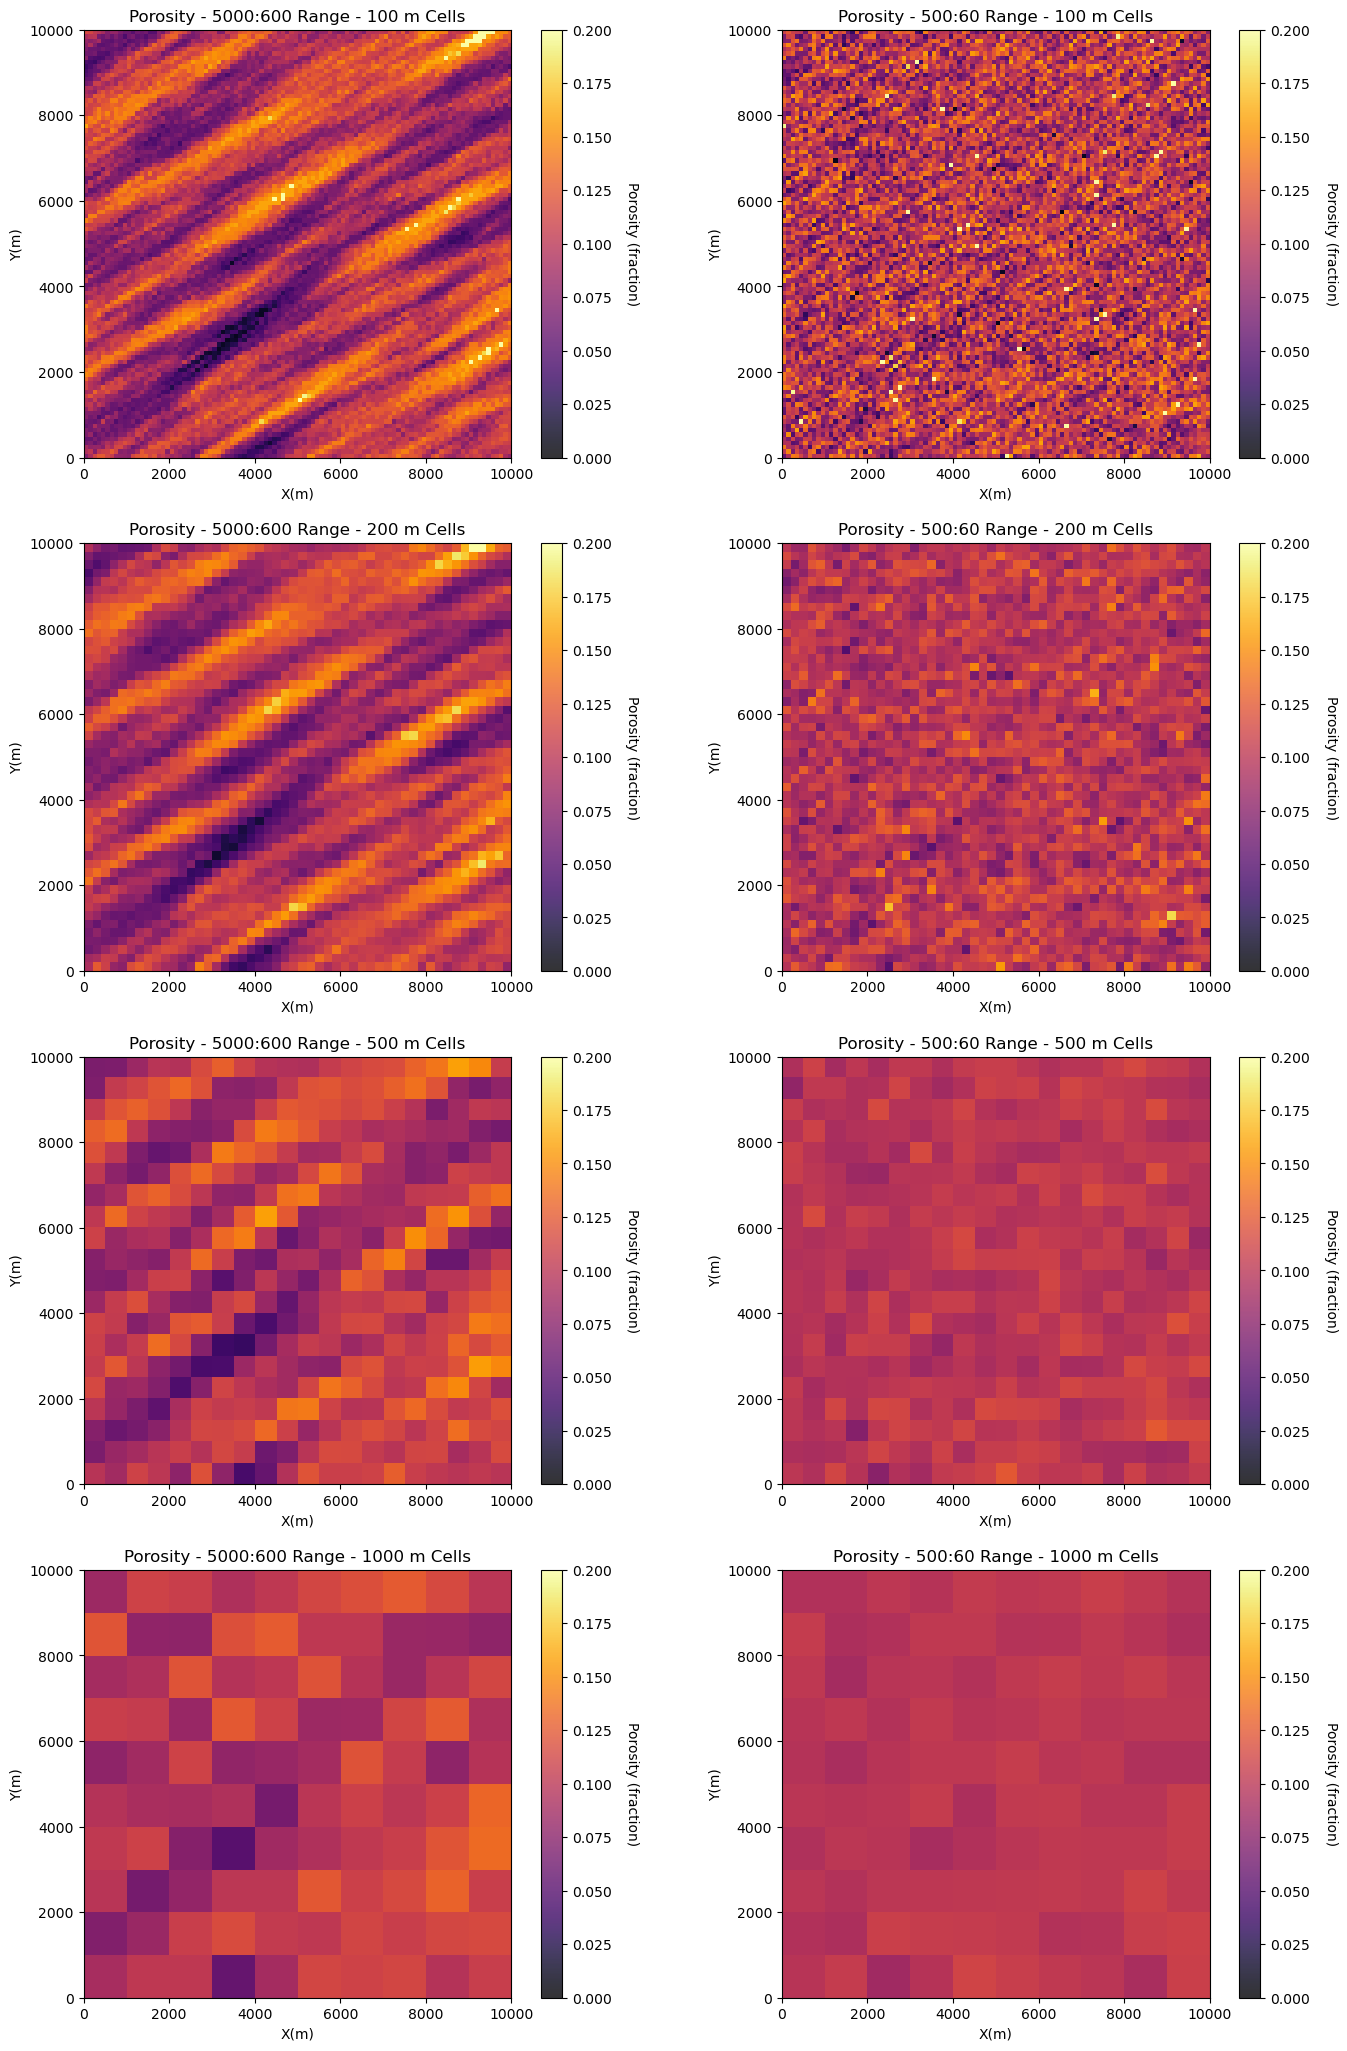

In [7]:
%%capture --no-display  

range_maj1 = 5000; range_min1 = 600                           # set spatial continuity ranges for both models
range_maj2 = 500; range_min2 = 60

vario1 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=range_maj1,hmin1=range_min1)

sim1 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario1)[0]

sim1 = GSLIB.affine(sim1,.1,0.03)                             # correct the distribution to a target mean and standard deviation.

vario2 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=range_maj2,hmin1=range_min2)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario2)[0]

sim2 = GSLIB.affine(sim2,.1,0.03)                             # correct the distribution to a target mean and standard deviation.

plt.subplot(421)
GSLIB.pixelplt_st(sim1,xmin,xmax,ymin,ymax,xsiz,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(422)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,xsiz,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

mid = upscale(sim1,new_nx = 50,new_ny = 50)
mid2 = upscale(sim2,new_nx = 50,new_ny = 50)

plt.subplot(423)
GSLIB.pixelplt_st(mid,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(424)
GSLIB.pixelplt_st(mid2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

midb = upscale(sim1,new_nx = 20,new_ny = 20)
midb2 = upscale(sim2,new_nx = 20,new_ny = 20)

plt.subplot(425)
GSLIB.pixelplt_st(midb,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(426)
GSLIB.pixelplt_st(midb2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

course = upscale(sim1,new_nx = 10,new_ny = 10)
course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
GSLIB.pixelplt_st(course,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 1000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(428)
GSLIB.pixelplt_st(course2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 1000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.1, wspace=0.2, hspace=0.2)
#plt.savefig('F4_Eg_EUR_Real_Pad.tif',dpi=300,bbox_inches="tight")
plt.show()

Let's observe the impact of upscaling scaling on the two model's distributions and variances. 

* first one with long spatial continuity and then one with short spatial continuity

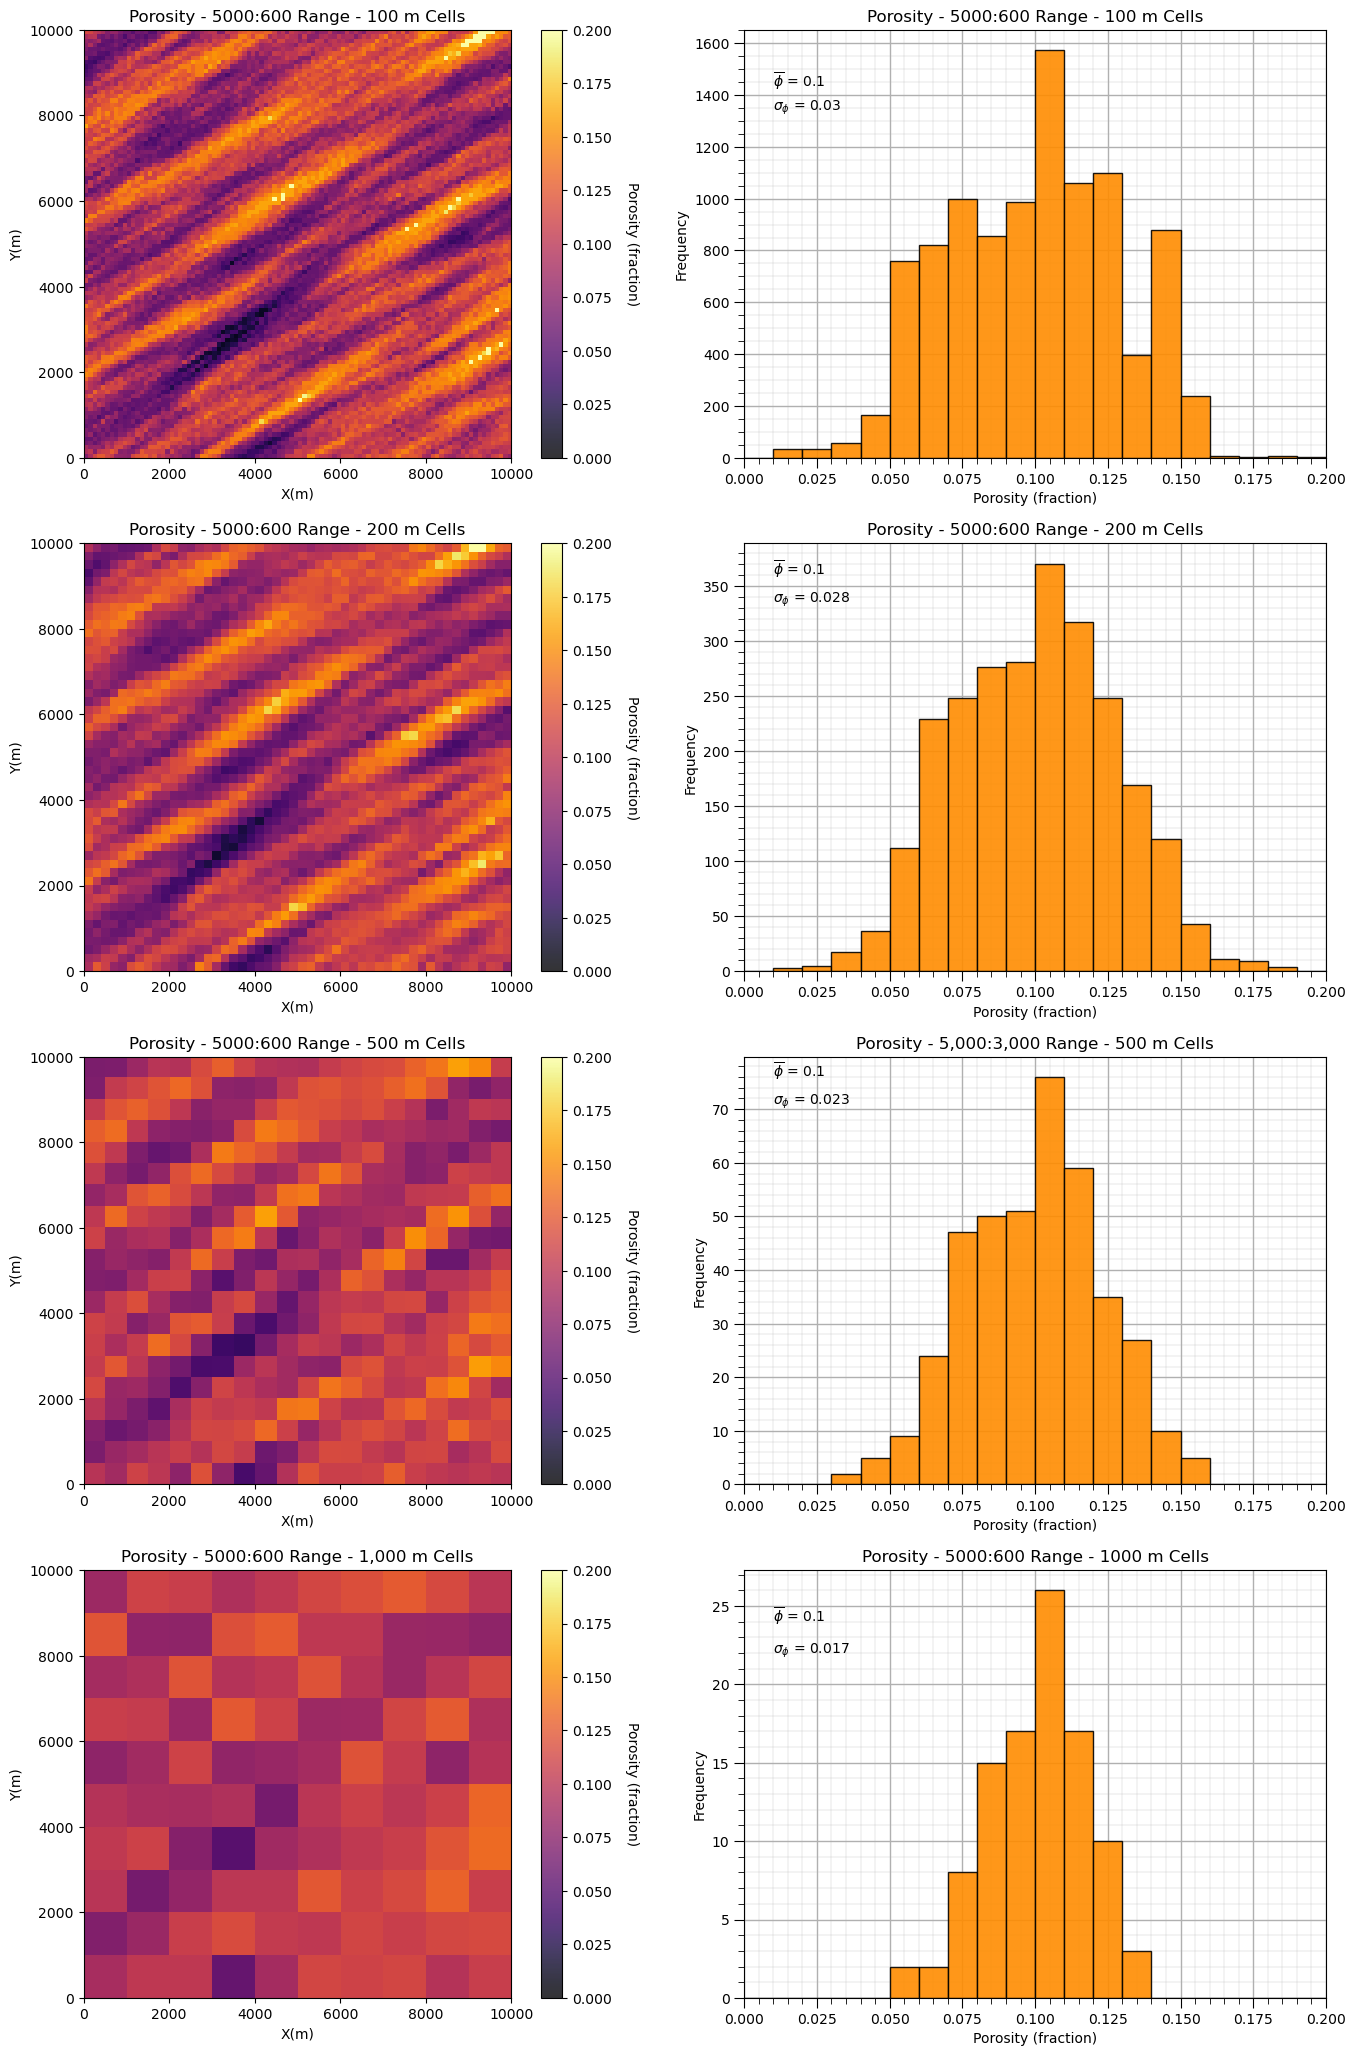

In [8]:
plt.subplot(421)
GSLIB.pixelplt_st(sim1,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(422)
GSLIB.hist_st(sim1.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj1) + ':' + str(range_min1) + ' Range - 100 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(sim1.flatten()),3)),[0.01,1430])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(sim1.flatten()),3)),[0.01,1340]); add_grid()

mid = upscale(sim1,new_nx = 50,new_ny = 50)

plt.subplot(423)
GSLIB.pixelplt_st(mid,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(424)
GSLIB.hist_st(mid.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj1) + ':' + str(range_min1) + ' Range - 200 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(mid.flatten()),3)),[0.01,360])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(mid.flatten()),3)),[0.01,335]); add_grid()

midb = upscale(sim1,new_nx = 20,new_ny = 20)

plt.subplot(425)
GSLIB.pixelplt_st(midb,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(426)
GSLIB.hist_st(midb.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",
              title='Porosity - 5,000:3,000 Range - 500 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(midb.flatten()),3)),[0.01,76])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(midb.flatten()),3)),[0.01,71]); add_grid()

course = upscale(sim1,new_nx = 10,new_ny = 10)

plt.subplot(427)
GSLIB.pixelplt_st(course,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + 
                  ' Range - 1,000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(428)
GSLIB.hist_st(course.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj1) + ':' + str(range_min1) + ' Range - 1000 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(course.flatten()),3)),[0.01,24])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(course.flatten()),3)),[0.01,22]); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.1, wspace=0.2, hspace=0.2)
#plt.savefig('sim1_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()

and now the model with shorter range, isotropic spatial continuity.

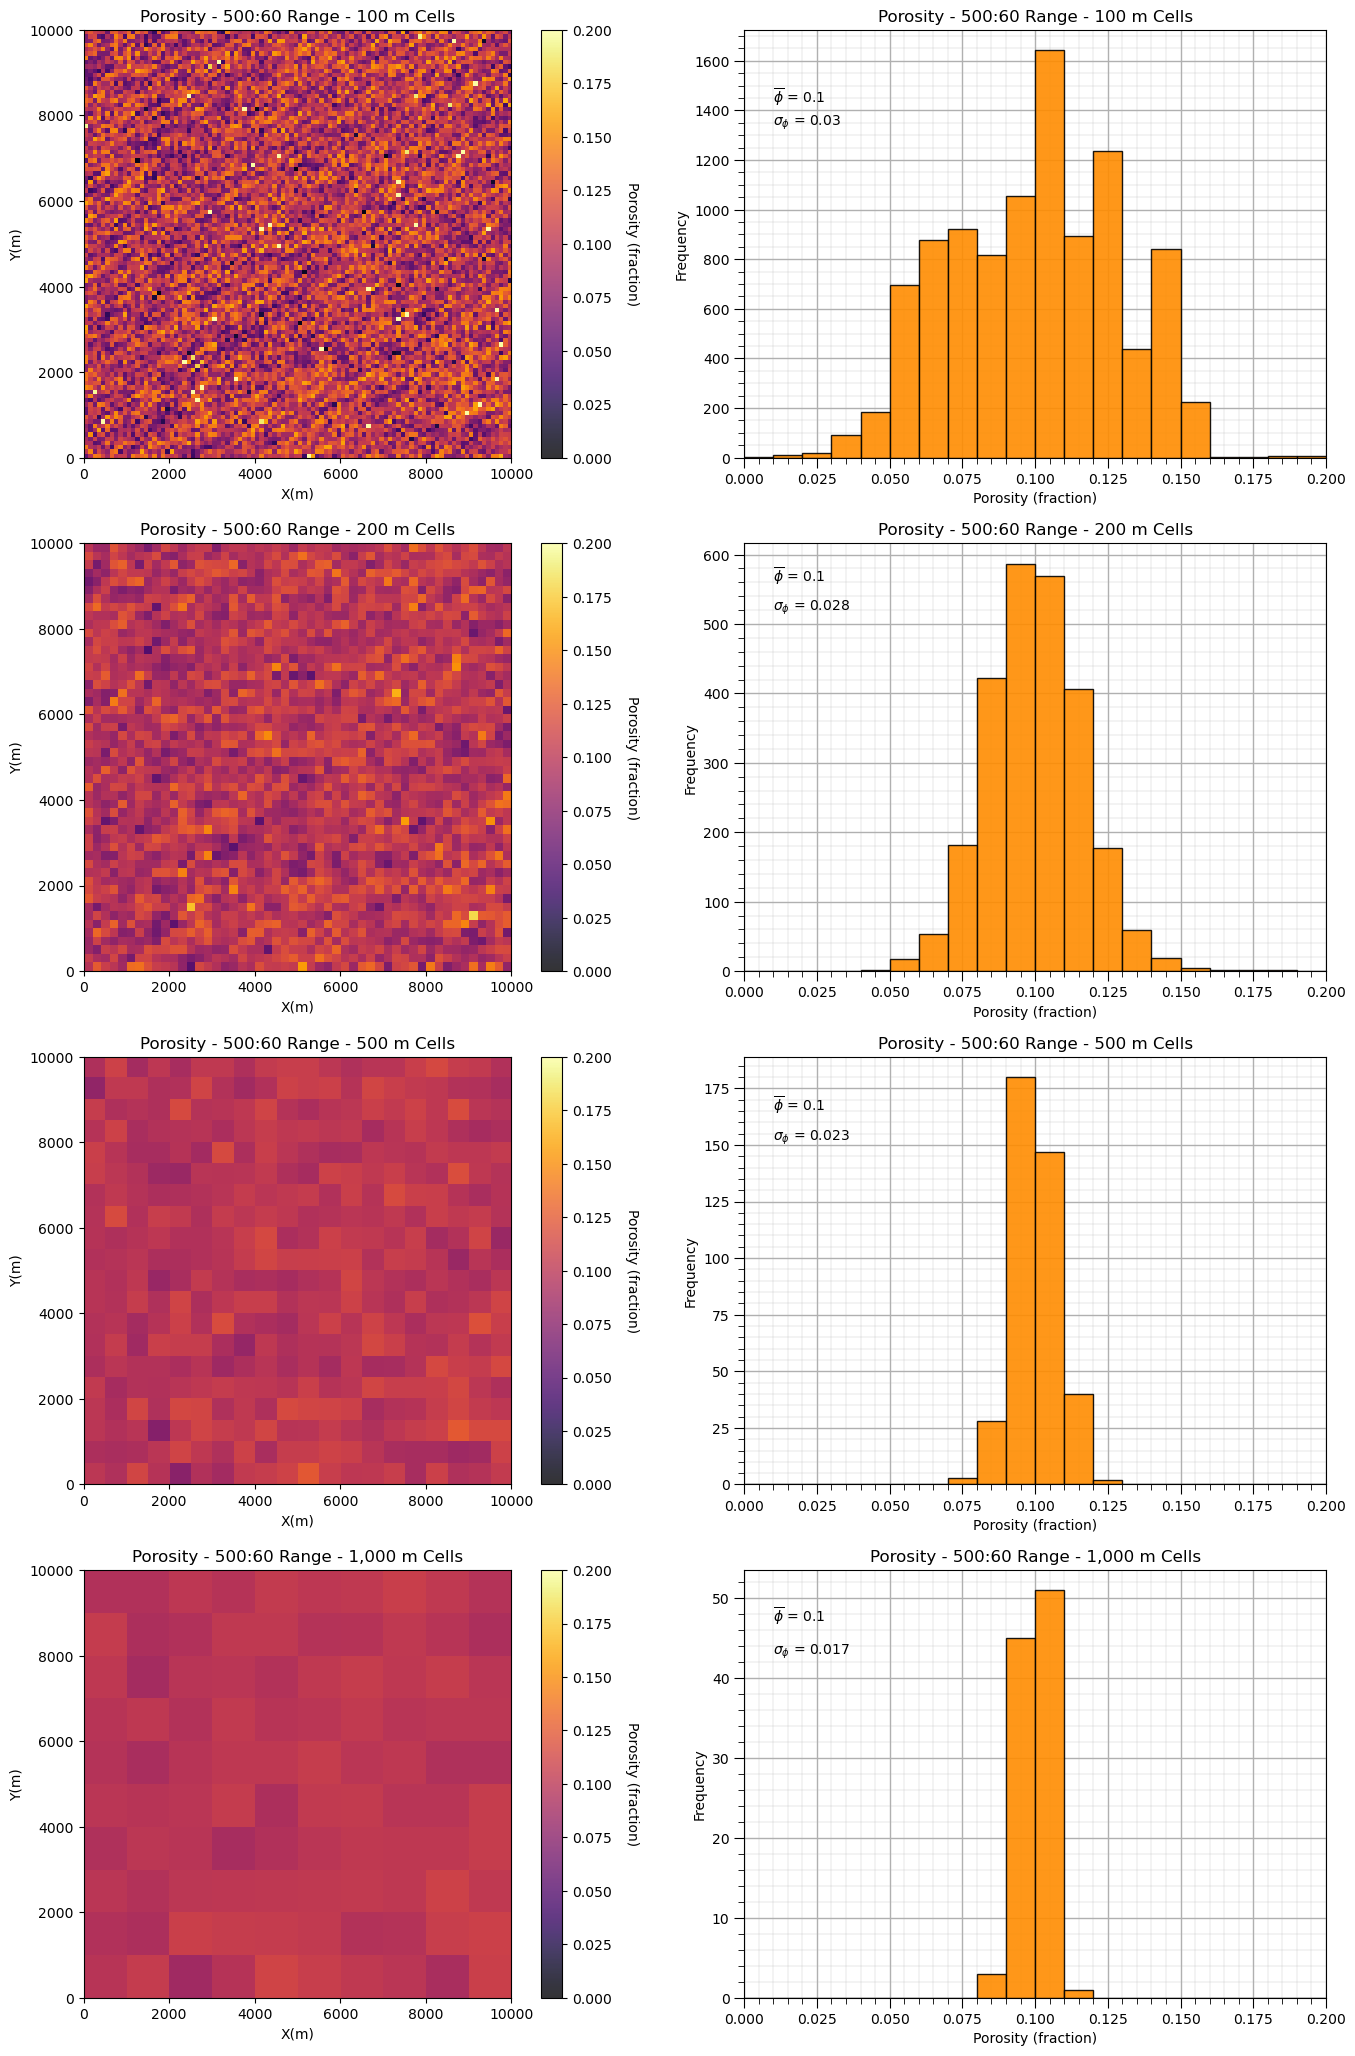

In [9]:
plt.subplot(421)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(422)
GSLIB.hist_st(sim2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj2) + ':' + str(range_min2) + ' Range - 100 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(sim1.flatten()),3)),[0.01,1430])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(sim1.flatten()),3)),[0.01,1340]); add_grid()

mid2 = upscale(sim2,new_nx = 50,new_ny = 50)

plt.subplot(423)
GSLIB.pixelplt_st(mid2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(424)
GSLIB.hist_st(mid2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj2) + ':' + str(range_min2) + ' Range - 200 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(mid.flatten()),3)),[0.01,560])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(mid.flatten()),3)),[0.01,520]); add_grid()

midb2 = upscale(sim2,new_nx = 20,new_ny = 20)

plt.subplot(425)
GSLIB.pixelplt_st(midb2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(426)
GSLIB.hist_st(midb2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj2) + ':' + str(range_min2) + ' Range - 500 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(midb.flatten()),3)),[0.01,165])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(midb.flatten()),3)),[0.01,152]); add_grid()

course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
GSLIB.pixelplt_st(course2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + 
                  ' Range - 1,000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(428)
GSLIB.hist_st(course2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(range_maj2) + ':' + str(range_min2) + ' Range - 1,000 m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(course.flatten()),3)),[0.01,47])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(course.flatten()),3)),[0.01,43]); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.1, wspace=0.2, hspace=0.2)
#plt.savefig('sim2_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()

We can see that with shorter ranges of spatial continuity, our variance reduces faster as we increase the support volume, i.e., the model cell size.

Let's loop over multiple upscaled grid cell sizes and calculate the resulting variance and standard deviation and then plot it to observe the relationship between volume support and variance, i.e., the volume-variance relationship.

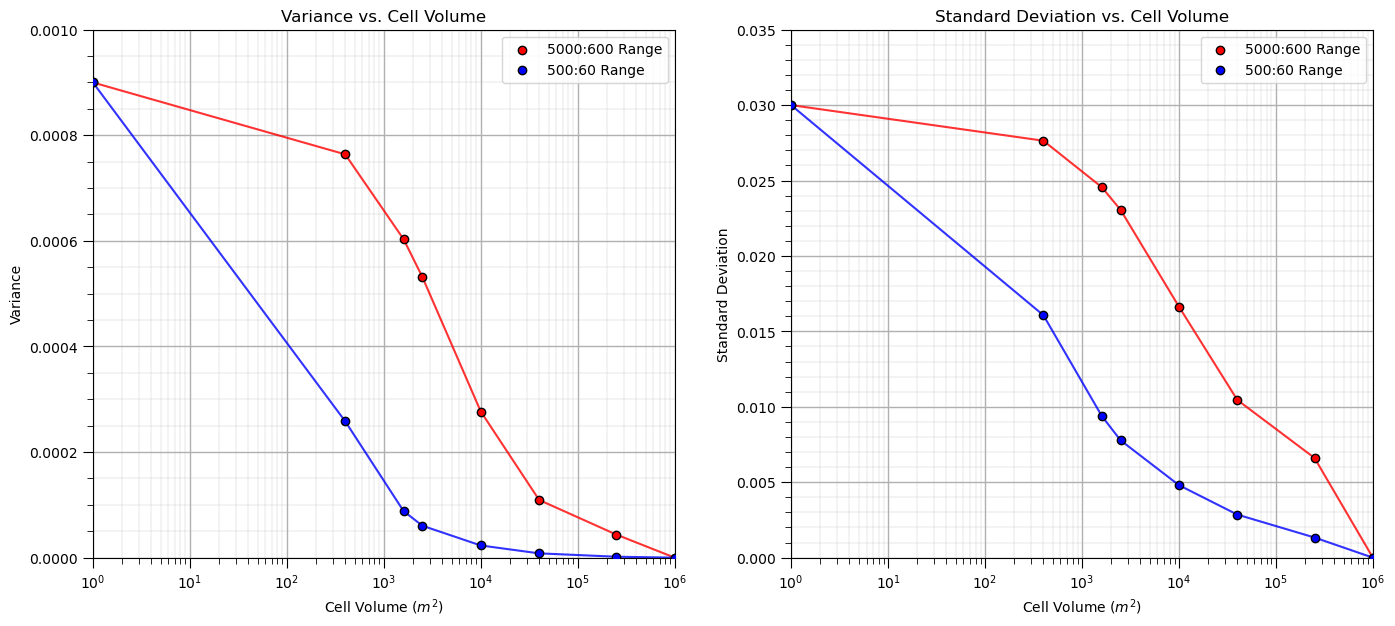

In [10]:
scale = []; var1 = []; var2 = []; std1 = []; std2 = []; ns = [50,25,20,10,5,2,1]
scale.append(1.0); var1.append(np.var(sim1)); var2.append(np.var(sim2)); std1.append(np.std(sim1)); std2.append(np.std(sim2))

for i,nc in enumerate(ns):                                    # loop over cases and perform upscaling              
    scale.append((1000/nc)*(1000/nc))
    scale1 = upscale(sim1,new_nx = nc,new_ny = nc)
    scale2 = upscale(sim2,new_nx = nc,new_ny = nc)
    var1.append(np.var(scale1)); var2.append(np.var(scale2))
    std1.append(np.std(scale1)); std2.append(np.std(scale2))

plt.subplot(121)
plt.plot(scale,var1,color='red',zorder=1,alpha=0.8)
plt.scatter(scale,var1,color='red',edgecolor='black',zorder=100,label=str(range_maj1) + ':' + str(range_min1) + ' Range')
plt.plot(scale,var2,color='blue',zorder=1,alpha=0.8)
plt.scatter(scale,var2,color='blue',edgecolor='black',zorder=100,label=str(range_maj2) + ':' + str(range_min2) + ' Range')
plt.xlim([1,1000000]); plt.ylim([0,0.001]); plt.xlabel('Cell Volume ' + r'$(m^2)$'); plt.ylabel('Variance')
plt.legend(loc = 'upper right'); plt.title('Variance vs. Cell Volume'); add_grid(); plt.xscale('log')

plt.subplot(122)
plt.plot(scale,std1,color='red',zorder=1,alpha=0.8)
plt.scatter(scale,std1,color='red',edgecolor='black',zorder=100,label=str(range_maj1) + ':' + str(range_min1) + ' Range')
plt.plot(scale,std2,color='blue',zorder=1,alpha=0.8)
plt.scatter(scale,std2,color='blue',edgecolor='black',zorder=100,label=str(range_maj2) + ':' + str(range_min2) + ' Range')
plt.xlim([1,1000000]); plt.ylim([0,0.035]); plt.xlabel('Cell Volume ' + r'$(m^2)$'); plt.ylabel('Standard Deviation')
plt.legend(loc = 'upper right'); plt.title('Standard Deviation vs. Cell Volume'); add_grid(); plt.xscale('log')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)
#plt.savefig('plot_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()

It is convenient to represent this as variance reduction factors,

* ratio of the variance at a specific volume support, i.e., cell size, relative to the original data support variance.

* we are demonstrating a empirical method for calculation variance reduction factors, next we will demonstrate the analytical approach based on the variogram, that will use variance reduction factors calculated from dispersion variance

Note, we don't need variance reduction factors for the empirical approach, as we already have the corrected distribution with the correct variance, but I thought it would be an interesting way to visualize these results.

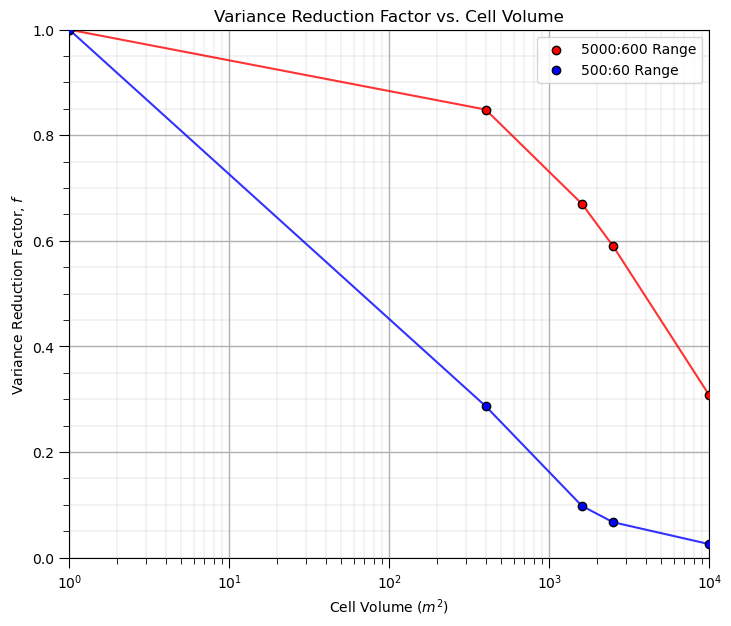

In [11]:
vrf1 = var1/var1[0]
vrf2 = var2/var2[0]

plt.subplot(111)
plt.plot(scale,vrf1,color='red',zorder=1,alpha=0.8)
plt.scatter(scale,vrf1,color='red',edgecolor='black',zorder=100,label=str(range_maj1) + ':' + str(range_min1) + ' Range')
plt.plot(scale,vrf2,color='blue',zorder=1,alpha=0.8)
plt.scatter(scale,vrf2,color='blue',edgecolor='black',zorder=100,label=str(range_maj2) + ':' + str(range_min2) + ' Range')
plt.xlim([1,10000]); plt.ylim([0,1]); plt.xlabel('Cell Volume ' + r'$(m^2)$'); plt.ylabel('Variance Reduction Factor, $f$')
plt.legend(loc = 'upper right'); plt.title('Variance Reduction Factor vs. Cell Volume'); add_grid(); plt.xscale('log')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2)
#plt.savefig('plot_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()

Since we've gone this far, let's complete a larger experiment by looping over many variogram ranges and model volume supports and visualize the variance reduction.

* this will provide an opportunity to compare the empirical to the analytical methods for volume-variance and distribution correction.

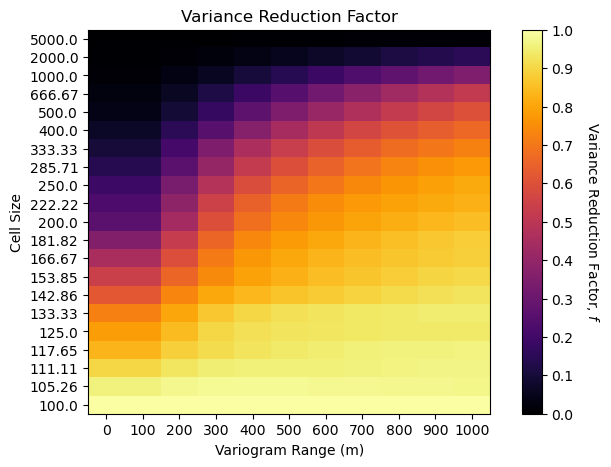

In [12]:
%%capture --no-display  

nc_mat = np.arange(0,103,5); nc_mat[0] = 2
range_mat = np.arange(0, 1001, 100); range_mat[0] = 0
f_mat = np.zeros((len(nc_mat),len(range_mat)))

for irange, crange in enumerate(range_mat):                                    # loop over cases and perform upscaling 
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=crange,hmin1=crange)

    sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario)[0]

    sim = GSLIB.affine(sim,.1,0.03)                             # correct the distribution to a target mean and standard deviation.
    fine_var = np.var(sim1.flatten())
    for inc,nc in enumerate(nc_mat):                                    # loop over cases and perform upscaling              
        scale.append((100/nc)*(100/nc))
        sim_up = upscale(sim,new_nx = nc,new_ny = nc)
        f_mat[inc,irange] = np.var(sim_up.flatten())/fine_var

num_xticks = len(range_mat); num_yticks = len(nc_mat)
im = plt.imshow(f_mat,cmap = cmap,vmin = 0.0, vmax = 1.0,aspect = 0.5)
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0.0,1.0,11))
cbar.set_label(r'Variance Reduction Factor, $f$', rotation=270, labelpad=20)
plt.xlabel('Variogram Range (m)'); plt.ylabel('Cell Size'); plt.title('Variance Reduction Factor')
xtick_positions = np.linspace(0, f_mat.shape[1] - 1, num_xticks)
ytick_positions = np.linspace(0, f_mat.shape[0] - 1, num_yticks)
xtick_labels = range_mat; ytick_labels = np.round(10000/nc_mat,2)
plt.xticks(xtick_positions, xtick_labels); plt.yticks(ytick_positions, ytick_labels)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

See the trade-off between volume support, as a function of cell size, and the variogram range?

* low variogram range more slowly reducing variance with increase in volume support

* low variogram range with small cell size has the same variance reduction factor as large variogram range with large cell size

#### Analytical Volume-Variance and Distribution Correction

Now I demonstrate the analytical volume-variance and distribution correction with variance inflation factors, 

$$
f = \frac{D^2(v,V)}{D^2(\cdot,V)} = \frac{D^2(v,V)}{\sigma^2}
$$

and we calculate, 

$$
D^2(v,V) = \overline{\gamma}_{V,V} - \overline{\gamma}_{v,v} 
$$

where $\overline{\gamma}_{V,V}$ and $\overline{\gamma}_{v,v}$ are variogram models integrated over volume $V$ and $v$ respectively. We do this with the gammabar function from GeostatsPy, currently this function is embedded in the workflow, but it will soon be added to GeostatsPy,

````python
def gammabar(size,ndiscr,vario):
````

where,

* **size** - the 2D square model cell size, assuming istropic volumes, $v$

* **ndiscr** - number of regular points for numerical approximization of the gammabar value

* **vario** - variogram value

Here's an example gammabar calculation, I initialized it with cell size and variogram model parameters,

* cell size - 10 m x 10 m

* variogram - isotropic spherical with a range of 20 m

In [13]:
vrange = 200; sill = 1.0
range_maj = vrange; range_min = vrange                           # set spatial continuity ranges for both models
ndiscr = 7; Vsize = 10000.0
vsize = 500.0 

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=sill,azi1=0.0,hmaj1=range_maj,hmin1=range_min)

gammabar_vv = gammabar(size=vsize,ndiscr=ndiscr,vario=vario)
gammabar_VV = gammabar(size=Vsize,ndiscr=ndiscr,vario=vario)

dispersion_vV = gammabar_VV - gammabar_vv
vrf = dispersion_vV/sill
print(vrf)

0.06596077172243309


Now we repeat the full combinatorial of variogram ranges and model cell sizes.

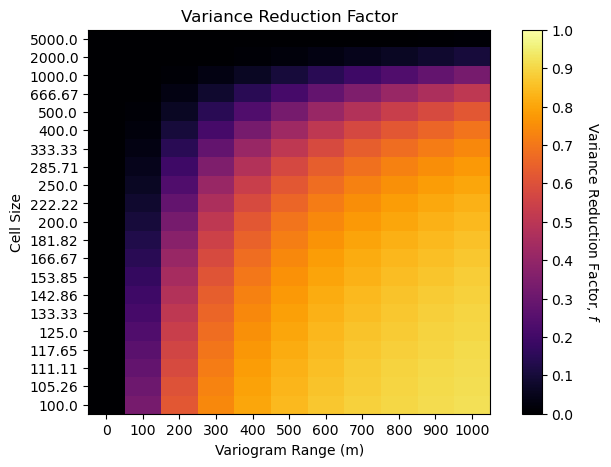

In [14]:
f_mat_gammabar = np.zeros((len(nc_mat),len(range_mat)))

Vsize = 10000
for irange, crange in enumerate(range_mat):                                    # loop over cases and perform upscaling 
    crange = max(0.00000001,crange)
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=crange,hmin1=crange)
    for inc,nc in enumerate(nc_mat):                                    # loop over cases and perform upscaling              
        vsize = 10000/nc
        gammabar_vv = gammabar(size=vsize,ndiscr=ndiscr,vario=vario)
        gammabar_VV = gammabar(size=Vsize,ndiscr=ndiscr,vario=vario)

        dispersion_vV = gammabar_VV - gammabar_vv
        f_mat_gammabar[inc,irange] = dispersion_vV/sill

num_xticks = len(range_mat); num_yticks = len(nc_mat)
im = plt.imshow(f_mat_gammabar,cmap = cmap,vmin = 0.0, vmax = 1.0,aspect = 0.5)
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0.0,1.0,11))
cbar.set_label(r'Variance Reduction Factor, $f$', rotation=270, labelpad=20)
plt.xlabel('Variogram Range (m)'); plt.ylabel('Cell Size'); plt.title('Variance Reduction Factor')
xtick_positions = np.linspace(0, f_mat.shape[1] - 1, num_xticks)
ytick_positions = np.linspace(0, f_mat.shape[0] - 1, num_yticks)
xtick_labels = range_mat; ytick_labels = np.round(10000/nc_mat,2)
plt.xticks(xtick_positions, xtick_labels); plt.yticks(ytick_positions, ytick_labels)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

Now let's compare the empirical and analytical methods with variogram reduction factor heat maps.

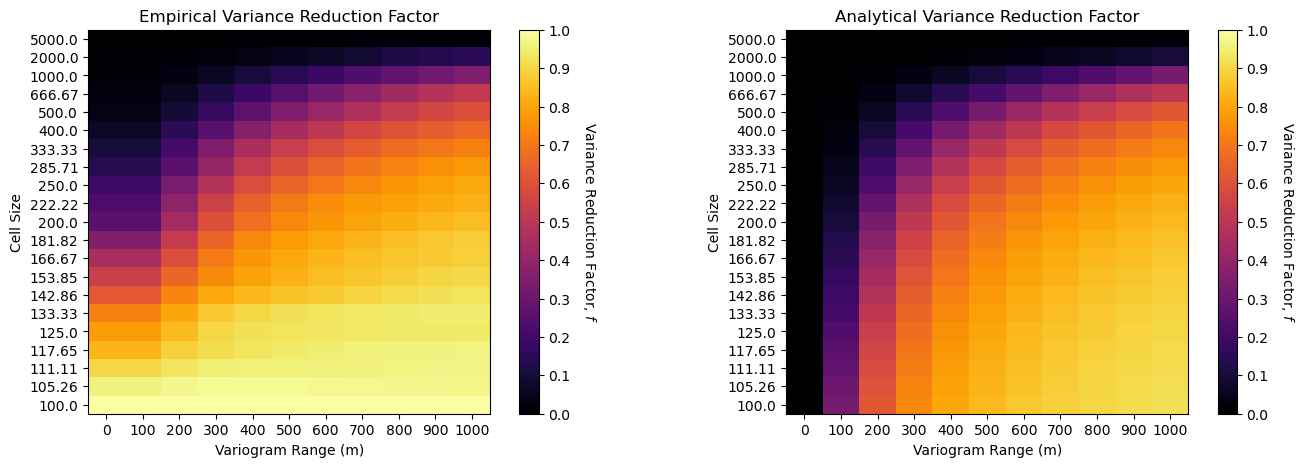

In [15]:
num_xticks = len(range_mat); num_yticks = len(nc_mat)

plt.subplot(121)
im = plt.imshow(f_mat,cmap = cmap,vmin = 0.0, vmax = 1.0,aspect = 0.5)
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0.0,1.0,11))
cbar.set_label(r'Variance Reduction Factor, $f$', rotation=270, labelpad=20)
plt.xlabel('Variogram Range (m)'); plt.ylabel('Cell Size'); plt.title('Empirical Variance Reduction Factor')
xtick_positions = np.linspace(0, f_mat.shape[1] - 1, num_xticks)
ytick_positions = np.linspace(0, f_mat.shape[0] - 1, num_yticks)
xtick_labels = range_mat; ytick_labels = np.round(10000/nc_mat,2)
plt.xticks(xtick_positions, xtick_labels); plt.yticks(ytick_positions, ytick_labels)

plt.subplot(122)
im = plt.imshow(f_mat_gammabar,cmap = cmap,vmin = 0.0, vmax = 1.0,aspect = 0.5)
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0.0,1.0,11))
cbar.set_label(r'Variance Reduction Factor, $f$', rotation=270, labelpad=20)
plt.xlabel('Variogram Range (m)'); plt.ylabel('Cell Size'); plt.title('Analytical Variance Reduction Factor')
xtick_positions = np.linspace(0, f_mat.shape[1] - 1, num_xticks)
ytick_positions = np.linspace(0, f_mat.shape[0] - 1, num_yticks)
xtick_labels = range_mat; ytick_labels = np.round(10000/nc_mat,2)
plt.xticks(xtick_positions, xtick_labels); plt.yticks(ytick_positions, ytick_labels)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

Firstly, both results are quite similar with 2 important differences,

1. variogram range of 0 (nugget effect only) is the same as 100 m range for the empirical case - this is due to the limitation of the origional model to $100 \times 100 m$ cell size so we cannot observe spatial continuity ranges less than $100 m$

2. for the small cell size cases, $\lt 200 m$ the variance reduction is underestimated (closer to 1.0), likely also due to the limited resolution of the original model (same as above).

#### Analytical Volume-Variance Workflows

Now we can demonstrate an analytical volume variance correction, changes the size of the model cells from, labeled as small and large below,

* let's start with the original distribution, assuming Gaussian for convenience

* calculate the variance reduction factor

* apply the affine correction for a change of support model

* visualize the result

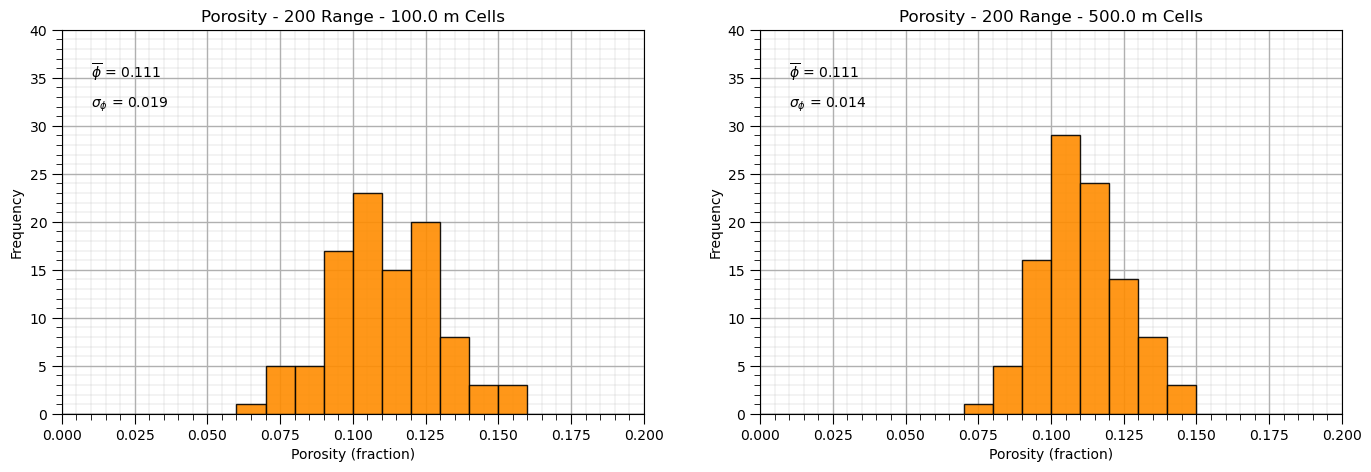

In [16]:
%%capture --no-display  

seed = 13
np.random.seed(seed = seed)

small_mean = 0.11; small_stdev = 0.02                            # initial small volume suppport distribution
vsize = 100.0                                                    # initial model cell size

vrange = 200; sill = small_stdev*small_stdev                    # variogram
range_maj = vrange; range_min = vrange                           
ndiscr = 7                                                       # number of discretizations for gammabar

Vsize = 500.0                                                   # new model cells size

small_values = np.random.normal(loc = small_mean, scale = small_stdev,size=100) 

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=sill,azi1=0.0,hmaj1=range_maj,hmin1=range_min)

gammabar_vv = gammabar(size=vsize,ndiscr=ndiscr,vario=vario)
gammabar_VV = gammabar(size=Vsize,ndiscr=ndiscr,vario=vario)

dispersion_vV = gammabar_VV - gammabar_vv
vrf = dispersion_vV/(small_stdev*small_stdev)
print(vrf)

large_values = math.sqrt(vrf) * (small_values - small_mean) + small_mean

plt.subplot(121)
GSLIB.hist_st(small_values,0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(vrange) + ' Range - ' + str(vsize) + ' m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(small_values),3)),[0.01,35])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(small_values),3)),[0.01,32]); add_grid()
plt.ylim([0,40]); plt.xlim([0.0,0.2])

plt.subplot(122)
GSLIB.hist_st(large_values,0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(vrange) + ' Range - ' + str(Vsize) + ' m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(large_values),3)),[0.01,35])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(large_values),3)),[0.01,32]); add_grid()
plt.ylim([0,40]); plt.xlim([0.0,0.2])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

and now let's demonstrate volume-variance correction from point volume support data, volume of the data is so small that it can be neglected, to model volume support. 

* this simplifies as the dispersion variance, $D^2(v,v) = 0.0$

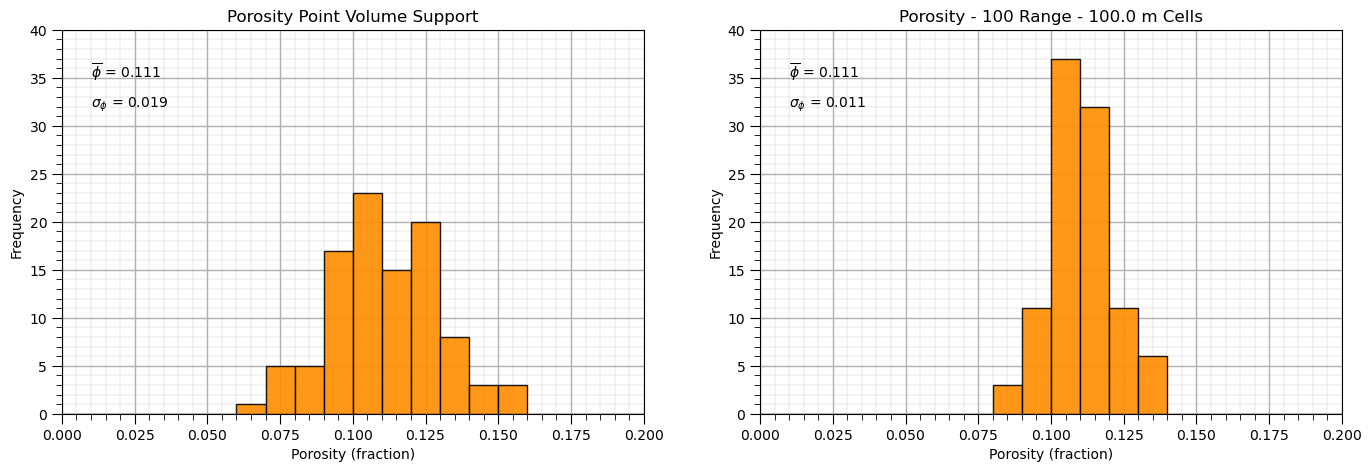

In [17]:
%%capture --no-display  

seed = 13
np.random.seed(seed = seed)

small_mean = 0.11; small_stdev = 0.02                            # initial small volume suppport distribution

vrange = 100; sill = small_stdev*small_stdev                     # variogram
range_maj = vrange; range_min = vrange                           
ndiscr = 7                                                       # number of discretizations for gammabar

vsize = 100.0                                                    # new model cells size

small_values = np.random.normal(loc = small_mean, scale = small_stdev,size=100) 

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=sill,azi1=0.0,hmaj1=vrange,hmin1=vrange)

gammabar_vv = gammabar(size=vsize,ndiscr=ndiscr,vario=vario)

vrf = 1.0 - gammabar_vv/(small_stdev*small_stdev) + 0.000000001
print(vrf)

large_values = math.sqrt(vrf) * (small_values - small_mean) + small_mean

plt.subplot(121)
GSLIB.hist_st(small_values,0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity Point Volume Support')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(small_values),3)),[0.01,35])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(small_values),3)),[0.01,32]); add_grid()
plt.ylim([0,40]); plt.xlim([0.0,0.2])

plt.subplot(122)
GSLIB.hist_st(large_values,0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + 
              str(vrange) + ' Range - ' + str(vsize) + ' m Cells')
plt.annotate(r'$\overline{\phi}$ = ' + str(np.round(np.average(large_values),3)),[0.01,35])
plt.annotate(r'$\sigma_{\phi}$ = ' + str(np.round(np.std(large_values),3)),[0.01,32]); add_grid()
plt.ylim([0,40]); plt.xlim([0.0,0.2])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration empirical scaling to demonstrate volume-variance relations. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)